# Salary Prediction with Job Postings data

The aim of this project is to build and deploy a machine learning model to predict the salaries of employees

### Why is this important?

A practical use of this is for a HR Department of a large company or a Consulting Outfit that needs real-time solutions in order to make effective employment offers to potential hires.

It also finds use in getting to understand current realities in the job market and how businesses can leverage this in order to secure high quality talent, whilst keeping hiring costs low.

# What is the Objective of this model?

We aim to minimize instances where we make overpriced or underpriced offers to new hires. We will evaluate model performance with:

1. Mean Squared Error (MSE)
2. Root Mean Squared Error (RMSE)
3. r-squared (R<sup>2</sup>)


## Exploratory Data Analysis

Load the datasets after importing relevant libraries and packages

In [1]:
#import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

In [2]:
train_features = pd.read_csv('../data/train_features.csv')
train_label = pd.read_csv('../data/train_salaries.csv')
test_data = pd.read_csv('../data/test_features.csv')

In [3]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_label.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
test_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


We will merge the `train_features` and `train_label` to yield the train dataset

In [6]:
train_data = train_features.merge(train_label, how="inner", on="jobId")
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [7]:
# Drop jobid, just a unique identifier for each job posting
train_data.drop('jobId', axis=1, inplace=True)

train_data.shape

(1000000, 8)

The Job Postings Dataset contains 1,000,000 rows and 8 columns

7 are predictors and 1 is the target variable

# Analysis

*We will analyze the following:*

1. The Label(Target Variable)

2. Feature Data Types (Categorical and Numerical)

3. Check for missing data

4. Numerical Features
    - Discrete or Continuous
    - Distributions
    - Transformations

5. Categorical Features
    - Cardinality
    - Presence of Rare Categories
    - Special mappings

## Label (Target Variable)

We shall begin with the Variable we're going to predict: `salary`

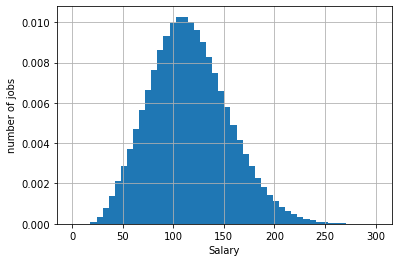

In [8]:
# Histogram to evaluate the target distribution

train_data['salary'].hist(bins=50, density=True)
plt.ylabel('number of jobs')
plt.xlabel('Salary')
plt.show()

We can see that the target is continuous, and the distribution is close to normal, though slightly skewed to the right.

We can move ahead to analyze the various variable types

## Variable Types

Let us identify the Categorical and numerical variables

In [13]:
# Capturing the Categorical variables (of type 'object')
cat_vars = [var for var in train_data.columns if train_data[var].dtype == 'O']
train_data[cat_vars].head()

,companyId,jobType,degree,major,industry
0,COMP37,CFO,MASTERS,MATH,HEALTH
1,COMP19,CEO,HIGH_SCHOOL,NONE,WEB
2,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH
3,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO
4,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE


In [14]:
# Number of Categorical Variables
len(cat_vars)

5

In [15]:
# Capturing the Numerical Variables
num_vars = [var for var in train_data.columns if var not in cat_vars and var != 'salary']
train_data[num_vars].head()

,yearsExperience,milesFromMetropolis
0,10,83
1,3,73
2,10,38
3,8,17
4,8,16


In [17]:
len(num_vars)

2

## Missing Values

Now, we shall find out which features contain missing values

In [20]:
# Make a list of the variables that contain missing values
vars_with_na = [var for var in train_data.columns if train_data[var].isnull().sum() > 0]

# Determine percent of missing data and display the results
train_data[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

There are no null values in the dataset. We confirm this by listing all the columns and datatypes

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   companyId            1000000 non-null  object
 1   jobType              1000000 non-null  object
 2   degree               1000000 non-null  object
 3   major                1000000 non-null  object
 4   industry             1000000 non-null  object
 5   yearsExperience      1000000 non-null  int64 
 6   milesFromMetropolis  1000000 non-null  int64 
 7   salary               1000000 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 68.7+ MB


## Numerical Variables

We have 2 numerical features in the dataset and we shall find out if either or both are discrete or continous

In [27]:
train_data[num_vars].head()

,yearsExperience,milesFromMetropolis
0,10,83
1,3,73
2,10,38
3,8,17
4,8,16


array([[<AxesSubplot:title={'center':'yearsExperience'}>,
        <AxesSubplot:title={'center':'milesFromMetropolis'}>]],
      dtype=object)

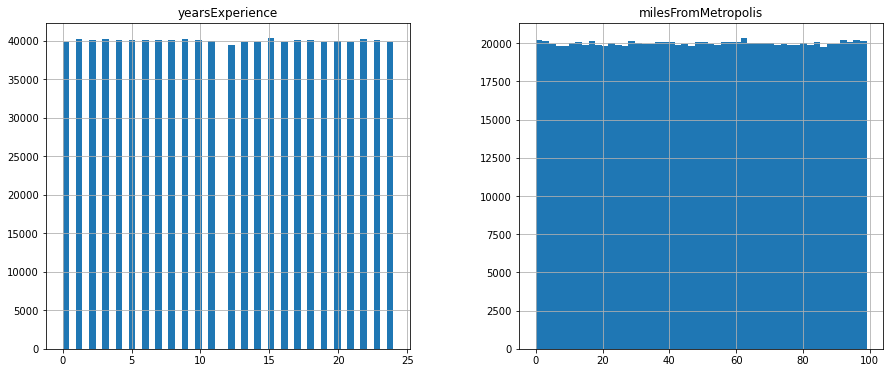

In [36]:
# Plotting histograms for the Numerical Features

train_data[num_vars].hist(bins=50, figsize=(15, 6))